In [ ]:
from pathlib import Path
from pyspark.sql import DataFrame, SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

spark = SparkSession.builder \
        .master('local[*]') \
        .config("spark.driver.memory", "15g") \
        .appName('spark') \
        .getOrCreate()

In [2]:
cwd = Path.cwd().parent

# Convert table with features to wide format

**Starting point:**
- Right now all data share the same features across datasources: effectDirection_up, effectDirection_down, effectSize_up, effectSize_down.
- Each row is a d/t association per data source + their features.

**Goal:**
- Convert to wide format in a way that one row constitutes one association and we have the set of features per datasource as columns.

In [3]:
all_data = spark.read.parquet(str(cwd / 'outputs/data_harmonisation'))

print(all_data.show(10))
all_data.groupBy('datasourceId').count().show()

+---------------+-------------+------------+--------------------+------------------+---------------+-------------+
|       targetId|    diseaseId|datasourceId|effectDirection_down|effectDirection_up|effectSize_down|effectSize_up|
+---------------+-------------+------------+--------------------+------------------+---------------+-------------+
|ENSG00000178057|MONDO_0005277|      chembl|                   0|                 1|              0|            1|
|ENSG00000137267|MONDO_0021117|      chembl|                   0|                20|              0|           20|
|ENSG00000168522|  EFO_0002618|      chembl|                   0|                 3|              0|            3|
|ENSG00000131747|MONDO_0001056|      chembl|                   0|                 9|              0|            9|
|ENSG00000185633|  EFO_0003047|      chembl|                   0|                 1|              0|            1|
|ENSG00000157388|  EFO_0007148|      chembl|                   0|               

+------------------+------+
|      datasourceId| count|
+------------------+------+
|            crispr|  1846|
|       gene_burden|  2874|
|            chembl| 70211|
|  expression_atlas|161620|
|           clinvar| 10275|
|          orphanet|  1757|
|    gene2phenotype|  2425|
|ot_genetics_portal|   114|
|              impc|523293|
+------------------+------+



In [4]:
import pandas as pd

pdf = all_data.toPandas()

pdf_wide = pd.pivot_table(pdf, index=['diseaseId', 'targetId'], columns=['datasourceId'], aggfunc=sum).reset_index().fillna(0)
pdf_wide.columns = pdf_wide.columns.map('_'.join).str.strip('_')

pdf_wide.head()


,diseaseId,targetId,effectDirection_down_chembl,effectDirection_down_clinvar,effectDirection_down_crispr,effectDirection_down_expression_atlas,effectDirection_down_gene2phenotype,effectDirection_down_gene_burden,effectDirection_down_impc,effectDirection_down_orphanet,...,effectSize_down_ot_genetics_portal,effectSize_up_chembl,effectSize_up_clinvar,effectSize_up_crispr,effectSize_up_expression_atlas,effectSize_up_gene2phenotype,effectSize_up_gene_burden,effectSize_up_impc,effectSize_up_orphanet,effectSize_up_ot_genetics_portal
0,DOID_10113,ENSG00000113578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DOID_10113,ENSG00000115758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DOID_13406,ENSG00000065989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DOID_13406,ENSG00000073417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DOID_13406,ENSG00000095464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Process Gold Standard

GS consists of all associations where directionality is supported by drugs.

**Target classes:**
- 1: up-regulated/positive evidence direction
- 2: up-regulated/negative evidence direction
- 3: down-regulated/positive evidence direction
- 4: down-regulated/negative evidence direction

In [ ]:
fm = spark.createDataFrame(pdf_wide)

fm.show()

In [41]:
gs = (
    fm
    .withColumn(
        'class',
        F.when((F.col('effectDirection_up_chembl') > 0) & (F.col('effectSize_up_chembl') > 0), 1)
        .when((F.col('effectDirection_up_chembl') > 0) & (F.col('effectSize_down_chembl') > 0), 2)
        .when((F.col('effectDirection_down_chembl') > 0) & (F.col('effectSize_up_chembl') > 0), 3)
        .when((F.col('effectDirection_down_chembl') > 0) & (F.col('effectSize_down_chembl') > 0), 4)
    )
    .filter(F.col('class').isNotNull())
    .distinct()
)

gs.show(1, False, True)

22/07/14 11:28:46 WARN TaskSetManager: Stage 30 contains a task of very large size (32322 KiB). The maximum recommended task size is 1000 KiB.


-RECORD 0--------------------------------------------------
 diseaseId                               | DOID_13406      
 targetId                                | ENSG00000073417 
 effectDirection_down_chembl             | 0.0             
 effectDirection_down_clinvar            | 0.0             
 effectDirection_down_crispr             | 0.0             
 effectDirection_down_expression_atlas   | 0.0             
 effectDirection_down_gene2phenotype     | 0.0             
 effectDirection_down_gene_burden        | 0.0             
 effectDirection_down_impc               | 0.0             
 effectDirection_down_orphanet           | 0.0             
 effectDirection_down_ot_genetics_portal | 0.0             
 effectDirection_up_chembl               | 2.0             
 effectDirection_up_clinvar              | 0.0             
 effectDirection_up_crispr               | 0.0             
 effectDirection_up_expression_atlas     | 0.0             
 effectDirection_up_gene2phenotype      

In [10]:
gs.count()

22/07/14 10:37:11 WARN TaskSetManager: Stage 19 contains a task of very large size (32322 KiB). The maximum recommended task size is 1000 KiB.


70211

# Train XGBoost Classifier


In [104]:
import numpy as np
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data = gs.drop('diseaseId', 'targetId', 'effectDirection_up_chembl', 'effectDirection_down_chembl', 'effectSize_up_chembl', 'effectSize_down_chembl').distinct().toPandas()

le = LabelEncoder()

X = data.drop('class', axis=1).copy()
y = le.fit(data['class']).transform(data['class'])

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


22/07/14 12:54:23 WARN TaskSetManager: Stage 41 contains a task of very large size (32322 KiB). The maximum recommended task size is 1000 KiB.


AxesSubplot(0.125,0.125;0.775x0.755)


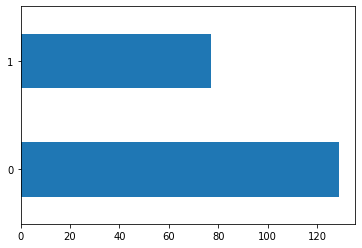

In [170]:
# Classes are really imbalanced - we give more importanced to the infrequent class with compute_sample_weight

print(pd.value_counts(y).plot.barh(x='class'))

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

### Some hyperparameter testing using k-fold cross validation

In [207]:
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt


def cross_validation(model, _X, _y, fit_params, _cv=5):
    '''Function to perform 5 Folds Cross-Validation
     Parameters
     ----------
    model: Python Class, default=None
            This is the machine learning algorithm to be used for training.
    fit_params: Python Dictionary with params to pass to the model.fit() method.
    _X: array
         This is the matrix of features.
    _y: array
         This is the target variable.
    _cv: int, default=5
        Determines the number of folds for cross-validation.
     Returns
     -------
     The function returns a dictionary containing the metrics 'accuracy', 'precision',
     'recall', 'f1' for both training set and validation set.
    '''

    _scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(
        estimator=model, X=_X, y=_y, cv=_cv, fit_params=fit_params, scoring=_scoring, return_train_score=True
    )

    return {
        "Training Accuracy scores": results['train_accuracy'],
        "Mean Training Accuracy": results['train_accuracy'].mean() * 100,
        "Training Precision scores": results['train_precision'],
        "Mean Training Precision": results['train_precision'].mean(),
        "Training Recall scores": results['train_recall'],
        "Mean Training Recall": results['train_recall'].mean(),
        "Training F1 scores": results['train_f1'],
        "Mean Training F1 Score": results['train_f1'].mean(),
        "Validation Accuracy scores": results['test_accuracy'],
        "Mean Validation Accuracy": results['test_accuracy'].mean() * 100,
        "Validation Precision scores": results['test_precision'],
        "Mean Validation Precision": results['test_precision'].mean(),
        "Validation Recall scores": results['test_recall'],
        "Mean Validation Recall": results['test_recall'].mean(),
        "Validation F1 scores": results['test_f1'],
        "Mean Validation F1 Score": results['test_f1'].mean(),
    }


def plot_result(x_label, y_label, plot_title, train_data, val_data):
    '''Function to plot a grouped bar chart showing the training and validation
     results of the ML model in each fold after applying K-fold cross-validation.
    Parameters
    ----------
    x_label: str,
       Name of the algorithm used for training e.g 'Decision Tree'

    y_label: str,
       Name of metric being visualized e.g 'Accuracy'
    plot_title: str,
       This is the title of the plot e.g 'Accuracy Plot'

    train_result: list, array
       This is the list containing either training precision, accuracy, or f1 score.

    val_result: list, array
       This is the list containing either validation precision, accuracy, or f1 score.
    Returns
    -------
    The function returns a Grouped Barchart showing the training and validation result
    in each fold.
    '''

    # Set size of plot
    plt.figure(figsize=(6, 4))
    labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
    X_axis = np.arange(len(labels))
    ax = plt.gca()
    plt.ylim(0.40000, 1)
    plt.bar(X_axis - 0.2, train_data, 0.4, label='Training')
    plt.bar(X_axis + 0.2, val_data, 0.4, label='Validation')
    plt.title(plot_title, fontsize=20)
    plt.xticks(X_axis, labels)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()


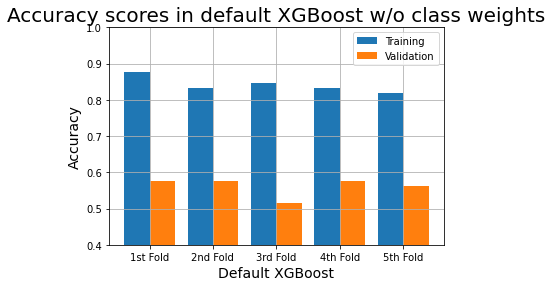

In [208]:
model_metrics = cross_validation(xgb.XGBClassifier(), X_train, y_train, fit_params={}, _cv=5)

plot_result(
    'Default XGBoost',
    'Accuracy',
    'Accuracy scores in default XGBoost w/o class weights',
    model_metrics['Training Accuracy scores'],
    model_metrics["Validation Accuracy scores"]
)

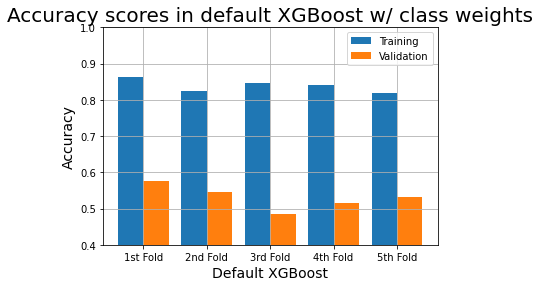

In [209]:
model_metrics = cross_validation(xgb.XGBClassifier(), X_train, y_train, fit_params={'sample_weight':sample_weights}, _cv=5)

plot_result(
    'Default XGBoost',
    'Accuracy',
    'Accuracy scores in default XGBoost w/ class weights',
    model_metrics['Training Accuracy scores'],
    model_metrics["Validation Accuracy scores"]
)

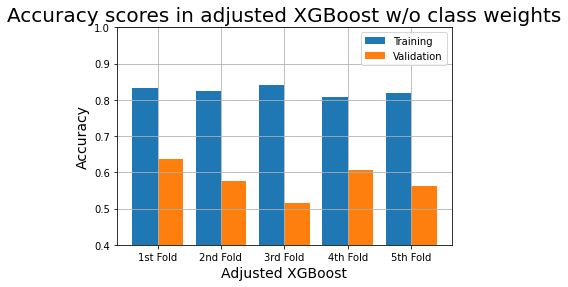

In [212]:
params = {
    #'objective': 'multi:softmax' if len(np.unique(y_train)) > 2 else 'binary:logistic',
    #'num_class': len(np.unique(y_train)),
    'random_state': 42,
    'learning_rate': 0.1,
    'eval_metric': 'merror' if len(np.unique(y_train)) > 2 else 'aucpr',
}

model_metrics = cross_validation(xgb.XGBClassifier(**params), X_train, y_train, fit_params={}, _cv=5)

plot_result(
    'Adjusted XGBoost',
    'Accuracy',
    'Accuracy scores in adjusted XGBoost w/o class weights',
    model_metrics['Training Accuracy scores'],
    model_metrics["Validation Accuracy scores"]
)

### Final model

The results of the parametrisation are not good enough to be used for the final model - I'll just use the default.

In [213]:
clf = xgb.XGBClassifier()
clf.fit(X_train.values, y_train)
pred = clf.predict(X_test.values)

In [ ]:
'''
Auxiliary code to plot feature importance from XGBoost

When training the model on a XGBoost matrix I can get to keep the original feature names, which is handy for the plot.
xgdmat = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)

clf2 = xgb.train(dtrain=xgdmat, params=params)

xgb.plot_importance(clf2)
'''


In [215]:
from sklearn.metrics import f1_score

acc = clf.score(X_test, y_test)
f1 = f1_score(y_test, pred)


print(f'Accuracy: {acc:.2f}')
print(f'F1 score: {f1:.2f}')

Accuracy: 0.48
F1 score: 0.39


# See feature importance with SHAP

In [37]:
import shap

shap.initjs()

In [235]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)

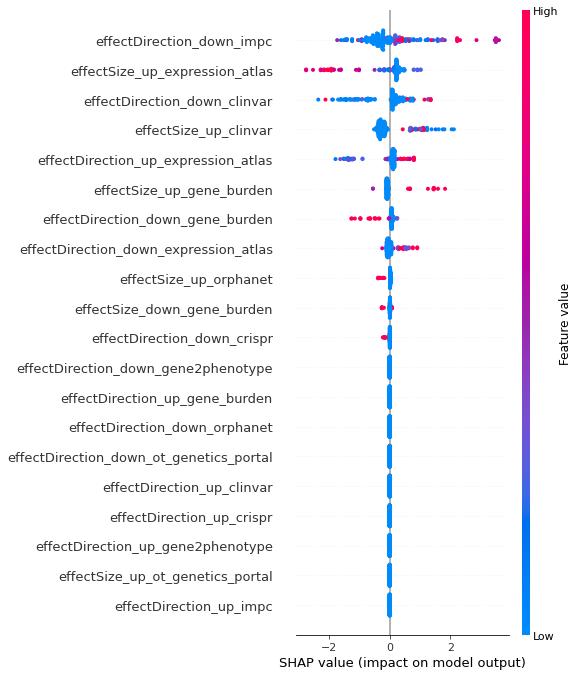

In [236]:
shap.summary_plot(shap_values, X)

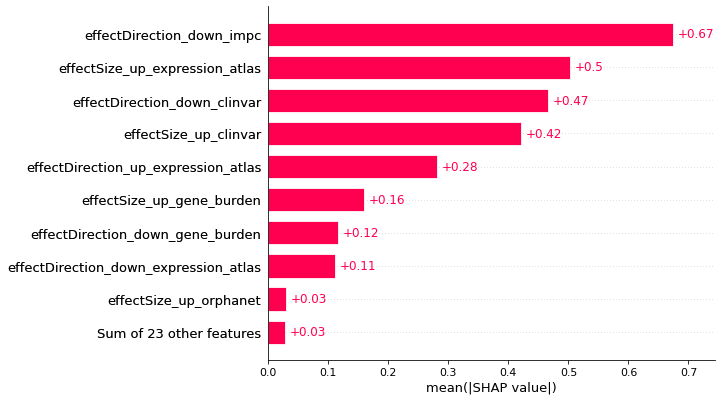

In [238]:
shap.plots.bar(shap_values)

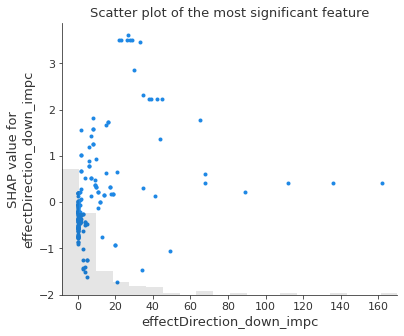

In [239]:
shap.plots.scatter(shap_values[:, 'effectDirection_down_impc'], title='Scatter plot of the most significant feature')

In [228]:
# Interaction Plot

# shap_interaction_values = explainer.shap_interaction_values(X)

# shap.summary_plot(shap_interaction_values, X)

In [233]:

shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

In [234]:
X.iloc[0, :]

effectDirection_down_clinvar               2.0
effectDirection_down_crispr                0.0
effectDirection_down_expression_atlas      0.0
effectDirection_down_gene2phenotype        0.0
effectDirection_down_gene_burden           0.0
effectDirection_down_impc                  0.0
effectDirection_down_orphanet              0.0
effectDirection_down_ot_genetics_portal    0.0
effectDirection_up_clinvar                 0.0
effectDirection_up_crispr                  0.0
effectDirection_up_expression_atlas        0.0
effectDirection_up_gene2phenotype          0.0
effectDirection_up_gene_burden             0.0
effectDirection_up_impc                    0.0
effectDirection_up_orphanet                0.0
effectDirection_up_ot_genetics_portal      0.0
effectSize_down_clinvar                    0.0
effectSize_down_crispr                     0.0
effectSize_down_expression_atlas           0.0
effectSize_down_gene2phenotype             0.0
effectSize_down_gene_burden                0.0
effectSize_do

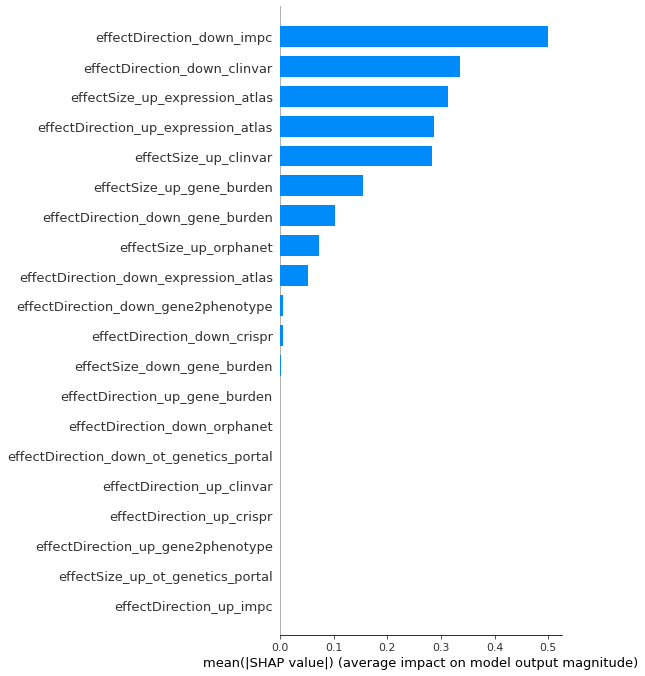

In [157]:
shap.summary_plot(shap_values, X_test, plot_type="bar")